# **1. Data Loading and Exploration**

In [ ]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import math
import time

# Sklearn libraries for machine learning and text processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# NLTK libraries for text processing (lemmatization, stemming, stopwords, POS tagging)
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Set up visualization
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# Download necessary NLTK resources for text processing
nltk.download('wordnet')  # WordNet for lemmatization
nltk.download('omw-1.4')  # Open Multilingual Wordnet
nltk.download('punkt')  # Tokenizer
nltk.download('stopwords')  # Stopwords for text cleaning
nltk.download('averaged_perceptron_tagger')  # POS tagger for part-of-speech tagging
nltk.download('tagsets_json')  # Tagset resource

# Define variables to store model outputs
accuracies={}
roc_auc={}

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets_json to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets_json.zip.


In [ ]:
!git clone https://github.com/ennovak/LLMs_Assignment_1.git

Cloning into 'LLMs_Assignment_1'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 2.77 MiB | 4.55 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
import pandas as pd
df_train = pd.read_excel('LLMs_Assignment_1/data/AI_vs_huam_train_dataset.xlsx')
df_test = pd.read_csv('LLMs_Assignment_1/data/Final_test_data.csv')

In [ ]:
df_train.head(10)

,essay,label
0,International sports events require the most w...,0
1,Globalisation has become a significant aspect ...,0
2,There is an ever-increasing number of bullying...,0
3,"It is commonly believed, that companies should...",0
4,Despite knowing about the adverse effects of c...,0
5,These days the space exploration is not just a...,0
6,Regarding the suggestions that governments sho...,0
7,The ability to associate at school has been a ...,0
8,"It is true that today, people tend to give bir...",0
9,Weather to have children or not is one of the ...,0


In [ ]:
df_train.describe()

,label
count,3728.000000
mean,0.500000
std,0.500067
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
df_train['essay']

,essay
0,International sports events require the most w...
1,Globalisation has become a significant aspect ...
2,There is an ever-increasing number of bullying...
3,"It is commonly believed, that companies should..."
4,Despite knowing about the adverse effects of c...
...,...
3723,I agree that successful people are willing to ...
3724,I believe that people who are open to trying n...
3725,"To succeed in life, we must do everything poss..."
3726,"I'm not entirely sure what the word ""successfu..."


In [ ]:
df_train.groupby('label').describe()

essay                                                               
      count unique                                                top freq
label                                                                     
0      1864   1864  Eessential way to succeed is trying new things...    1
1      1864   1864  The key to success is trying new things while ...    1

In [ ]:
df_test.head(10)

,essay,label
0,"Enjoyment means entertainment, satisfaction of...",NaN
1,Before to start with my opinion of the topic i...,NaN
2,"Thats a really really good subject, but acctul...",NaN
3,I disagree with the statement saying that it i...,NaN
4,It is undeniable that advertisements play a si...,NaN
5,I don't support the idea that is better to hav...,NaN
6,"In the pursuit of knowledge, the age-old debat...",NaN
7,It is undeniable that advertisements play a cr...,NaN
8,The statement that young people nowadays do no...,NaN
9,The world of advertising is a captivating real...,NaN


In [ ]:
# Compute essay length as the number of words in each essay
df_train['essay_len'] = df_train['essay'].apply(lambda x: len(x.split()))

# Print the overall average length
overall_avg = df_train['essay_len'].mean()
print("Overall average essay length (in words):", overall_avg)

# Print the average length for human-written vs AI
avg_per_label = df_train.groupby('label')['essay_len'].mean()
print("Average tweet length for human-written vs AI:")
print(avg_per_label)

Overall average essay length (in words): 279.7671673819743
Average tweet length for human-written vs AI:
label
0    299.682940
1    259.851395
Name: essay_len, dtype: float64


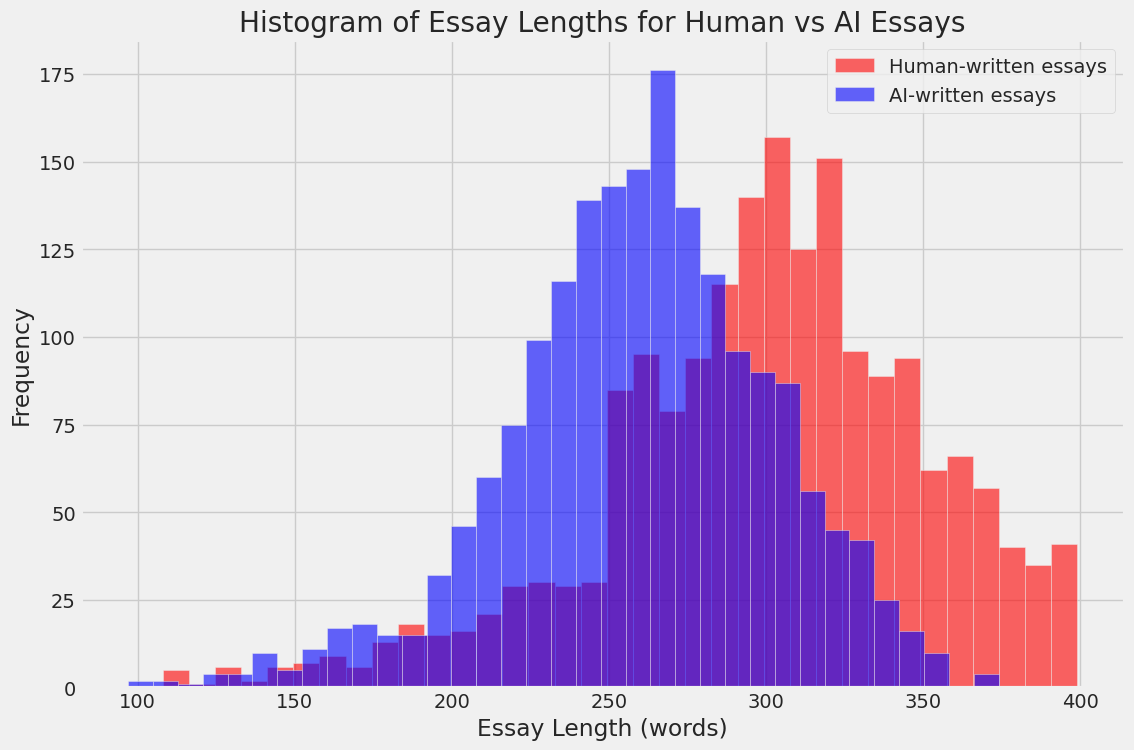

In [ ]:
# Plot histograms for each label
plt.figure(figsize=(12, 8))

df_train[df_train.label == 0].essay_len.plot(
    bins=35, kind='hist', color='red', alpha=0.6, label='Human-written essays'
)
df_train[df_train.label == 1].essay_len.plot(
    bins=35, kind='hist', color='blue', alpha=0.6, label='AI-written essays'
)

plt.xlabel("Essay Length (words)")
plt.ylabel("Frequency")
plt.title("Histogram of Essay Lengths for Human vs AI Essays")
plt.legend()
plt.show()

# **2. Text Preprocessing Functions**

**2.1: Stop Words Removal**

In [ ]:
def text_process(essay):
    """
    Cleans and processes a string.

    This function takes a raw string and performs several text cleaning steps:
    1. Checks if the input is a string; returns an empty string otherwise.
    2. Defines a list of common English stopwords.
    3. Removes all punctuation from the string.
    4. Removes the defined stopwords from the string.
    5. Joins the remaining words back into a single cleaned string.

    Args:
        essay (str): The input string to be processed.

    Returns:
        str: The cleaned string with punctuation and stopwords removed,
             or an empty string if the input was not a string.
    """
    # Handle non-string values gracefully
    if not isinstance(essay, str):
        return ""

    # Define a set of standard English stopwords
    STOPWORDS = stopwords.words('english')

    # Remove punctuation from the string
    nopunc = ''.join([char for char in essay if char not in string.punctuation])

    # Remove stopwords and join the words back into a string
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [ ]:
# Show vocab before stopword removal
train_vocab_bf = set(" ".join(df_train['essay']).split())
test_vocab_bf = set(" ".join(df_test['essay']).split())

print("=== Vocabulary statistics before stopword removal ===")
print(f"Train unique words : {len(train_vocab_bf):,}")
print(f"Test  unique words : {len(test_vocab_bf):,}")

=== Vocabulary statistics before stopword removal ===
Train unique words : 42,702
Test  unique words : 16,261


In [ ]:
# Quick peek at words
print("Sample train words :", sorted(list(train_vocab_bf))[:1000], "...\n")
print("Sample test  words :", sorted(list(test_vocab_bf))[:1000], "...\n")

Sample train words : ['!', '!!', '!.', '"', '",', '".', '"10', '"2000', '"3', '"3M",', '"A', '"ABC".Eventhough', '"Abdul', '"Ahimsa"', '"Ahimsa,"', '"Aim', '"Alexa"', '"Apply"', '"Apply."', '"Arnold",', '"BE', '"Babble"(A', '"Babel"', '"Bard', '"Big', '"Bioinformatics"', '"Bourse"', '"By', '"Change', '"Charles', '"Club', '"Clubhouse"', '"Comple', '"Complete', '"Corsa",', '"Dandy', '"Divine', '"Do', '"Dolly"', '"Don\'t', '"Education', '"El', '"English', '"Euphoria."', '"Every', '"Experience', '"FAILURES', '"Failures', '"Faster,', '"Fate"', '"Father', '"Fosburry"', '"Gandhi".He', '"Get', '"Good', '"Google"', '"Google,"', '"HARDWORK', '"Harvard', '"High', '"Higher', '"Horiemon"', '"Hotmail."', '"How', '"I', '"IN', '"If', '"In', '"Innovation', '"Intel"', '"Internet', '"I‚Äôm', '"Jack', '"Knowing', '"La', '"Life', '"MOTHER"', '"Made', '"Mahatma', '"Malavoglia",', '"Men', '"Mercado', '"Mickey', '"More', '"Mother', '"Mother"', '"Mother."', '"NO', '"Never', '"New', '"Newton"', '"No', '"No",', 

In [ ]:
# Apply text cleaning to the "essay" column
df_train['clean_essay'] = df_train['essay'].apply(text_process)
df_test['clean_essay'] = df_test['essay'].apply(text_process)

# Show vocab after stopword removal
train_vocab = set(" ".join(df_train['clean_essay']).split())
test_vocab = set(" ".join(df_test['clean_essay']).split())

print("=== Vocabulary statistics after stopword removal ===")
print(f"Train unique words : {len(train_vocab):,}")
print(f"Test  unique words : {len(test_vocab):,}")

=== Vocabulary statistics after stopword removal ===
Train unique words : 29,014
Test  unique words : 11,546


In [ ]:
# Quick peek at words
print("Sample train words :", sorted(list(train_vocab))[:1000], "...\n")
print("Sample test  words :", sorted(list(test_vocab))[:1000], "...\n")

Sample train words : ['000', '002', '1', '10', '100', '1000', '10000', '100inch', '100meter', '100mts', '100th', '10year', '11', '12', '1200', '120000', '12yearold', '13', '1492', '14th', '14thcentury', '15', '150', '1500', '15th', '15whileother', '16', '160', '16M', '17', '170', '1789', '18', '1800s', '18th', '18thcentury', '19', '1900s', '1903', '1919', '1920s', '1923', '1923In', '1928', '1930s', '1941', '19411942', '1950s', '1960s', '1963', '1970s', '1980', '1980s', '1984', '1988', '1990', '1990s', '1991', '1994', '1995', '1998', '19th', '1hrthis', '1paragraph', '1st', '1v1', '1‚Äîbut', '2', '20', '200', '2000', '20000', '2000s', '2001', '2003', '2005', '2006', '2008', '2009', '200In', '200meter', '200mts', '2013', '2014', '2016', '2017', '2018', '2020', '2021', '2022', '2050', '20s', '20th', '20years', '21', '21st', '22', '228', '23', '2426C', '2426¬∞C', '247', '25', '250', '26', '27', '29', '2hour', '2nd', '3', '30', '300', '30000', '30000ayear', '30s', '30year', '34', '35', '3500

In [ ]:
df_train.head(10)

,essay,label,essay_len,clean_essay
0,International sports events require the most w...,0,269,International sports events require welltraine...
1,Globalisation has become a significant aspect ...,0,298,Globalisation become significant aspect world’...
2,There is an ever-increasing number of bullying...,0,255,everincreasing number bullying activities nume...
3,"It is commonly believed, that companies should...",0,318,commonly believed companies dress code policy ...
4,Despite knowing about the adverse effects of c...,0,320,Despite knowing adverse effects climate change...
5,These days the space exploration is not just a...,0,296,days space exploration imagination since human...
6,Regarding the suggestions that governments sho...,0,267,Regarding suggestions governments offord tuiti...
7,The ability to associate at school has been a ...,0,261,ability associate school great concern Owing a...
8,"It is true that today, people tend to give bir...",0,288,true today people tend give birth older previo...
9,Weather to have children or not is one of the ...,0,304,Weather children one important questions young...


**2.2: Stemming Techniques**

In [ ]:
# Stemming example

# Simple tokenization
tokens = set(" ".join(df_train['clean_essay']).split())

# Initialize the stemmer
stemmer = PorterStemmer()

# Apply stemming on the tokens
stemmed_tokens = [stemmer.stem(word) for word in tokens]

print("Tokens:", tokens)
print("Stemmed Tokens:", stemmed_tokens)

Tokens: {'rigt', 'perfect‚Äîthey', 'delegation', 'satement', 'media', 'leverage', 'accuont', 'Westinghouse', 'frames', 'beforIt', 'appearntly', 'injecting', 'feats', 'welfare', 'experiencence', 'nonverbal', 'overdiversification', 'constructive', 'charaterstics', 'groundless', 'telecommuting', 'police', 'situations', 'failurewhile', 'shorp', 'simplicity', 'personnal', 'courtseyEdison', 'thingsfor', 'ende', 'case‚Äîthey‚Äôre', 'gaining', 'unseemly', '‚ÄòNecessity', 'eitsh', 'some‚Äîlike', 'equpiment', 'consequence', 'thatthey', 'knowingly', 'Adam', 'day‚Äîand', 'miscalculate', 'Seconldy', 'new‚Äîit', 'facilitates', 'youngtherefore', 'seem', 'dangerus', 'finantially', 'somthing', 'efficiently', 'Nations', 'personson', 'this‚Äîthey', 'straties', 'scince', 'environmentally', 'withdrawn', 'intervent', 'perfectlyWhen', 'Leaving', 'racket', 'succeeded', '247', 'goespractice', 'opportunities‚Äù', 'GunHee', 'carriage', 'away‚Äîyou', 'retest', 'shift', 'asertion', 'ordinaly', 'trades', 'hillsI', 

**2.3: Lemmatization Techniques**

In [ ]:
# Lemmatization example

# Intialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization on the tokens
lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

print("Tokens:", tokens)
print("Lemmatized Tokens:", lemmatized_tokens)

Tokens: {'rigt', 'perfect‚Äîthey', 'delegation', 'satement', 'media', 'leverage', 'accuont', 'Westinghouse', 'frames', 'beforIt', 'appearntly', 'injecting', 'feats', 'welfare', 'experiencence', 'nonverbal', 'overdiversification', 'constructive', 'charaterstics', 'groundless', 'telecommuting', 'police', 'situations', 'failurewhile', 'shorp', 'simplicity', 'personnal', 'courtseyEdison', 'thingsfor', 'ende', 'case‚Äîthey‚Äôre', 'gaining', 'unseemly', '‚ÄòNecessity', 'eitsh', 'some‚Äîlike', 'equpiment', 'consequence', 'thatthey', 'knowingly', 'Adam', 'day‚Äîand', 'miscalculate', 'Seconldy', 'new‚Äîit', 'facilitates', 'youngtherefore', 'seem', 'dangerus', 'finantially', 'somthing', 'efficiently', 'Nations', 'personson', 'this‚Äîthey', 'straties', 'scince', 'environmentally', 'withdrawn', 'intervent', 'perfectlyWhen', 'Leaving', 'racket', 'succeeded', '247', 'goespractice', 'opportunities‚Äù', 'GunHee', 'carriage', 'away‚Äîyou', 'retest', 'shift', 'asertion', 'ordinaly', 'trades', 'hillsI', 

# **3. Feature Extraction**

In [ ]:
# Define X and Y
X = df_train['clean_essay']
Y = df_train['label']

In [ ]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (3728,)
Y shape: (3728,)


In [ ]:
# Train/validation split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

**1. TF-IDF Vectorization**

In [ ]:
# Instantiate TfidfVectorizer and fit on training data
vectorizer = TfidfVectorizer(
    max_features=30000,  # Limit vocabulary size for efficiency (given that the train dataset has ~29k unique words after stopword removal, 30k limitation should be appropriate)
    ngram_range=(1, 3),  # Use unigrams, bigrams, and trigrams
    min_df=2,           # Ignore terms that appear in less than 2 documents
    max_df=0.95         # Ignore terms that appear in more than 95% of documents
    )

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

print("\nTF-IDF Vectorizer vocabulary size:", len(vectorizer.get_feature_names_out()))
print("Sample features:", vectorizer.get_feature_names_out()[:5])


TF-IDF Vectorizer vocabulary size: 30000
Sample features: ['10' '10 years' '100' '1000' '10000']


In [ ]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 512925 stored elements and shape (2982, 30000)>

In [ ]:
# Train both Multinomial Naive Bayes and Logistic Regression models
start_time = time.time()

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, Y_train)

# Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_tfidf, Y_train)

end_time = time.time()
print("\nTraining Time: {:.3f} seconds".format(end_time - start_time))

# 7. Evaluate both models
# Make predictions on the validation set
y_pred_nb = nb.predict(X_val_tfidf)
y_pred_lr = lr.predict(X_val_tfidf)

# Calculate and print accuracy scores
print("\n=======Accuracy Scores===========")
acc_nb = metrics.accuracy_score(Y_val, y_pred_nb)
acc_lr = metrics.accuracy_score(Y_val, y_pred_lr)

print(f"Naive Bayes Accuracy    : {acc_nb*100:.2f}%")
print(f"Logistic Regression Accuracy : {acc_lr*100:.2f}%")

# Print confusion matrices
print("\n=======Confusion Matrix - Naive Bayes===========")
print(metrics.confusion_matrix(Y_val, y_pred_nb))

print("\n=======Confusion Matrix - Logistic Regression===========")
print(metrics.confusion_matrix(Y_val, y_pred_lr))

# Classification reports
print("\n=======Classification Report - Naive Bayes===========")
print(metrics.classification_report(Y_val, y_pred_nb, target_names=['0', '1']))

print("\n=======Classification Report - Logistic Regression===========")
print(metrics.classification_report(Y_val, y_pred_lr, target_names=['0', '1']))

# Show most informative features using log probabilities
print("\n=======Most Important Features===========")
feature_names = vectorizer.get_feature_names_out()

# Get log probabilities for each class
log_prob_AI = nb.feature_log_prob_[1]  # Class 1 (AI)
log_prob_human = nb.feature_log_prob_[0]  # Class 0 (human)

# Calculate the difference (higher = more indicative of AI-written)
feature_scores = log_prob_AI - log_prob_human

# Get top features for each class
top_AI_idx = feature_scores.argsort()[-10:][::-1]  # Top 10 AI features
top_human_idx = feature_scores.argsort()[:10]         # Top 10 human features

print("Top features for AI-written:")
for i in top_AI_idx:
    print(f"  {feature_names[i]}: {feature_scores[i]:.4f}")

print("\nTop features for human-written:")
for i in top_human_idx:
    print(f"  {feature_names[i]}: {feature_scores[i]:.4f}")


Training Time: 0.211 seconds

=======Accuracy Scores===========
Naive Bayes Accuracy    : 96.65%
Logistic Regression Accuracy : 97.18%

=======Confusion Matrix - Naive Bayes===========
[[353  20]
 [  5 368]]

=======Confusion Matrix - Logistic Regression===========
[[363  10]
 [ 11 362]]

=======Classification Report - Naive Bayes===========
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       373
           1       0.95      0.99      0.97       373

    accuracy                           0.97       746
   macro avg       0.97      0.97      0.97       746
weighted avg       0.97      0.97      0.97       746


=======Classification Report - Logistic Regression===========
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       373
           1       0.97      0.97      0.97       373

    accuracy                           0.97       746
   macro avg       0.97      0.97      0.97    

**2. Bag of Words**

In [ ]:
# Instantiate CountVectorizer and fit on training data
vectorizer = CountVectorizer(
    binary=True,        # Use binary features (presence/absence)
    max_features=30000, # Limit vocabulary size for efficiency (30k, same as before)
    ngram_range=(1, 2), # Use unigrams and bigrams
    min_df=2,          # Ignore terms that appear in less than 2 documents
    max_df=0.95        # Ignore terms that appear in more than 95% of documents
)
X_train_count = vectorizer.fit_transform(X_train)
X_val_count = vectorizer.transform(X_val)

print("\nCountVectorizer vocabulary size:", len(vectorizer.get_feature_names_out()))
print("Sample features:", vectorizer.get_feature_names_out()[:20])

# Train both Multinomial Naive Bayes and Logistic Regression models
start_time = time.time()

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_count, Y_train)

# Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_count, Y_train)

end_time = time.time()
print("\nTraining Time: {:.3f} seconds".format(end_time - start_time))

# 7. Evaluate both models
# Make predictions on the validation set
y_pred_class_nb = nb.predict(X_val_count)
y_pred_class_lr = lr.predict(X_val_count)

# Calculate and print the accuracy score
print("\n=======Accuracy Scores===========")
acc_nb = metrics.accuracy_score(Y_val, y_pred_nb)
acc_lr = metrics.accuracy_score(Y_val, y_pred_lr)

print(f"Naive Bayes Accuracy    : {acc_nb*100:.2f}%")
print(f"Logistic Regression Accuracy : {acc_lr*100:.2f}%")

# Print the confusion matrix
print("\n=======Confusion Matrix===========")
print(metrics.confusion_matrix(Y_val, y_pred_class_nb))
print(metrics.confusion_matrix(Y_val, y_pred_class_lr))

# Additional evaluation metrics
print("\n=======Classification Report===========")
print(metrics.classification_report(Y_val, y_pred_class_nb, target_names=['0','1']))
print(metrics.classification_report(Y_val, y_pred_class_lr, target_names=['0', '1']))

# Show most informative features using log probabilities
print("\n=======Most Important Features===========")
feature_names = vectorizer.get_feature_names_out()

# Get log probabilities for each class
log_prob_AI = nb.feature_log_prob_[1]  # Class 1 (AI)
log_prob_human = nb.feature_log_prob_[0]  # Class 0 (human)

# Calculate the difference (higher = more indicative of AI-written)
feature_scores = log_prob_AI - log_prob_human

# Get top features for each class
top_AI_idx = feature_scores.argsort()[-10:][::-1]  # Top 10 AI features
top_human_idx = feature_scores.argsort()[:10]         # Top 10 human features

print("Top features for AI-written:")
for i in top_AI_idx:
    print(f"  {feature_names[i]}: {feature_scores[i]:.4f}")

print("\nTop features for human-written:")
for i in top_human_idx:
    print(f"  {feature_names[i]}: {feature_scores[i]:.4f}")


CountVectorizer vocabulary size: 30000
Sample features: ['10' '10 20' '10 years' '100' '100 children' '100 shots' '100 years'
 '1000' '1000 people' '10000' '10year' '10year prison' '11' '12' '1200'
 '1200 ideas' '120000' '13' '15' '15 years']

Training Time: 0.315 seconds

=======Accuracy Scores===========
Naive Bayes Accuracy    : 96.65%
Logistic Regression Accuracy : 97.18%

=======Confusion Matrix===========
[[362  11]
 [  4 369]]
[[365   8]
 [  9 364]]

=======Classification Report===========
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       373
           1       0.97      0.99      0.98       373

    accuracy                           0.98       746
   macro avg       0.98      0.98      0.98       746
weighted avg       0.98      0.98      0.98       746

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       373
           1       0.98      0.98      0.98       373

    ac

# **4. Model Training and Hyperparameter Tuning**

**4.1: Support Vector Machine (SVM)**

In [ ]:
from sklearn import svm

# Instantiate CountVectorizer and fit on training data
vectorizer = CountVectorizer(
    binary=True,        # Use binary features (presence/absence)
    max_features=30000, # Limit vocabulary size for efficiency (30k, same as before)
    ngram_range=(1, 2), # Use unigrams and bigrams
    min_df=2,          # Ignore terms that appear in less than 2 documents
    max_df=0.95        # Ignore terms that appear in more than 95% of documents
)
X_train_svm = vectorizer.fit_transform(X_train)
X_val_svm = vectorizer.transform(X_val)

# Implement Support Vector Machine (SVM)
sc = svm.SVC(probability=True)
sc.fit(X_train_svm, Y_train)

# Make predictions
y_pred_svm = sc.predict(X_val_svm)

# Print accuracy score
print("=======Accuracy Score===========")
acc_svm = metrics.accuracy_score(Y_val, y_pred_svm)
print(f"SVM Accuracy: {acc_svm*100:.2f}%")

=======Accuracy Score===========
SVM Accuracy: 97.72%


In [ ]:
# Implement Support Vector Machine (SVM) using linear kernel
linear_svc = svm.SVC(kernel='linear')
linear_svc.fit(X_train_svm, Y_train)

# Make predictions
y_pred_linear = linear_svc.predict(X_val_svm)

# Print accuracy score
print("=======Accuracy Score===========")
acc_linear = metrics.accuracy_score(Y_val, y_pred_linear)
print(f"Linear Kernel Accuracy: {acc_linear*100:.2f}%")

=======Accuracy Score===========
Linear Kernel Accuracy: 97.99%


In [ ]:
# Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10],
			'gamma': [1, 0.1, 0.01],
			'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

grid.fit(X_train_svm, Y_train)

# Print best parameters
print(grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.499 total time=   8.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.499 total time=   7.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.448 total time=   7.8s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.461 total time=   9.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.460 total time=   7.5s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.499 total time=   7.8s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.499 total time=   7.8s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   7.6s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.502 total time=   7.7s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   7.8s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.856 total time=   7.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;,

In [ ]:
# Implement Support Vector Machine (SVM) using rbf kernel with optimized parameters
rbf_svc = svm.SVC(kernel='rbf', C=10, gamma=0.01)
rbf_svc.fit(X_train_svm, Y_train)

# Make predictions
y_pred_rbf = rbf_svc.predict(X_val_svm)

# Print accuracy score
print("=======Accuracy Score===========")
acc_rbf = metrics.accuracy_score(Y_val, y_pred_rbf)
print(f"RBF Kernel Accuracy: {acc_rbf*100:.2f}%")

=======Accuracy Score===========
RBF Kernel Accuracy: 96.92%


**4.2: Decision Tree**

In [ ]:
from sklearn import tree

# Instantiate CountVectorizer and fit on training data
vectorizer = CountVectorizer(
    binary=True,        # Use binary features (presence/absence)
    max_features=30000, # Limit vocabulary size for efficiency (30k, same as before)
    ngram_range=(1, 2), # Use unigrams and bigrams
    min_df=2,          # Ignore terms that appear in less than 2 documents
    max_df=0.95        # Ignore terms that appear in more than 95% of documents
)
X_train_dt = vectorizer.fit_transform(X_train)
X_val_dt = vectorizer.transform(X_val)

# Define decision tree
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train_dt, Y_train)

# Make predictions
y_pred_dt = dt.predict(X_val_dt)

# Print accuracy score
print("=======Accuracy Score===========")
acc_dt = metrics.accuracy_score(Y_val, y_pred_dt)
print(f"Decision Tree Accuracy: {acc_dt*100:.2f}%")

=======Accuracy Score===========
Decision Tree Accuracy: 93.16%


[Text(0.7823893229166666, 0.9821428571428571, 'x[29540] <= 0.5\ngini = 0.5\nsamples = 2982\nvalue = [1491, 1491]'),
 Text(0.6611328125, 0.9464285714285714, 'x[29750] <= 0.5\ngini = 0.346\nsamples = 1824\nvalue = [1418, 406]'),
 Text(0.7217610677083333, 0.9642857142857142, 'True  '),
 Text(0.5514322916666666, 0.9107142857142857, 'x[480] <= 0.5\ngini = 0.267\nsamples = 1669\nvalue = [1404, 265]'),
 Text(0.4309895833333333, 0.875, 'x[23921] <= 0.5\ngini = 0.198\nsamples = 1557\nvalue = [1384, 173]'),
 Text(0.3723958333333333, 0.8392857142857143, 'x[17320] <= 0.5\ngini = 0.166\nsamples = 1522\nvalue = [1383, 139]'),
 Text(0.2864583333333333, 0.8035714285714286, 'x[27043] <= 0.5\ngini = 0.086\nsamples = 1282\nvalue = [1224, 58]'),
 Text(0.25, 0.7678571428571429, 'x[20860] <= 0.5\ngini = 0.07\nsamples = 1265\nvalue = [1219, 46]'),
 Text(0.22916666666666666, 0.7321428571428571, 'x[29392] <= 0.5\ngini = 0.063\nsamples = 1259\nvalue = [1218, 41]'),
 Text(0.21875, 0.6964285714285714, 'x[22805] <

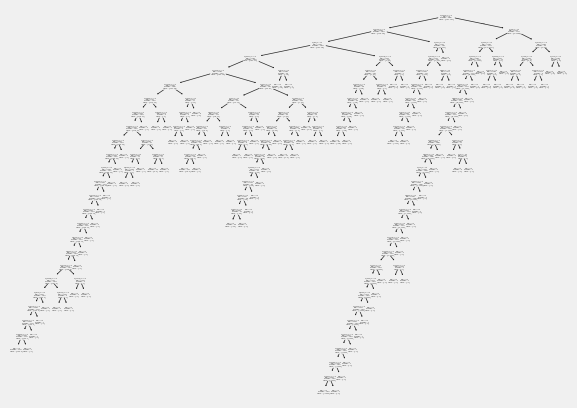

In [ ]:
tree.plot_tree(dt)

In [ ]:
# Define decision tree using gini criterion
dt_gini = tree.DecisionTreeClassifier(criterion='gini')
dt_gini = dt_gini.fit(X_train_dt, Y_train)

# Make predictions
y_pred_gini = dt_gini.predict(X_val_dt)

# Print accuracy score
print("=======Accuracy Score===========")
acc_gini = metrics.accuracy_score(Y_val, y_pred_gini)
print(f"Decision Tree Accuracy: {acc_gini*100:.2f}%")

=======Accuracy Score===========
Decision Tree Accuracy: 91.69%


In [ ]:
# Define decision tree using entropy criterion
dt_ent = tree.DecisionTreeClassifier(criterion='entropy')
dt_ent = dt_ent.fit(X_train_dt, Y_train)

# Make predictions
y_pred_entropy = dt_ent.predict(X_val_dt)

# Print accuracy score
print("=======Accuracy Score===========")
acc_entropy = metrics.accuracy_score(Y_val, y_pred_entropy)
print(f"Decision Tree Accuracy: {acc_entropy*100:.2f}%")

=======Accuracy Score===========
Decision Tree Accuracy: 92.09%


In [ ]:
# Define decision tree changing max depth
dt_d3 = tree.DecisionTreeClassifier(max_depth=3)
dt_d3 = dt_d3.fit(X_train_dt, Y_train)

# Make predictions
y_pred_d3 = dt_d3.predict(X_val_dt)

# Print accuracy score
print("=======Accuracy Score===========")
acc_d3 = metrics.accuracy_score(Y_val, y_pred_d3)
print(f"Decision Tree Accuracy: {acc_d3*100:.2f}%")

=======Accuracy Score===========
Decision Tree Accuracy: 91.69%


[Text(0.5, 0.875, 'x[29540] <= 0.5\ngini = 0.5\nsamples = 2982\nvalue = [1491, 1491]'),
 Text(0.25, 0.625, 'x[29750] <= 0.5\ngini = 0.346\nsamples = 1824\nvalue = [1418, 406]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[480] <= 0.5\ngini = 0.267\nsamples = 1669\nvalue = [1404, 265]'),
 Text(0.0625, 0.125, 'gini = 0.198\nsamples = 1557\nvalue = [1384, 173]'),
 Text(0.1875, 0.125, 'gini = 0.293\nsamples = 112\nvalue = [20, 92]'),
 Text(0.375, 0.375, 'x[1301] <= 0.5\ngini = 0.164\nsamples = 155\nvalue = [14, 141]'),
 Text(0.3125, 0.125, 'gini = 0.124\nsamples = 151\nvalue = [10, 141]'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.75, 0.625, 'x[468] <= 0.5\ngini = 0.118\nsamples = 1158\nvalue = [73, 1085]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[1990] <= 0.5\ngini = 0.096\nsamples = 1128\nvalue = [57.0, 1071.0]'),
 Text(0.5625, 0.125, 'gini = 0.084\nsamples = 1116\nvalue = [49, 1067]'),
 Text(0.6875, 0.125, 'gini = 0.444\nsamples = 12

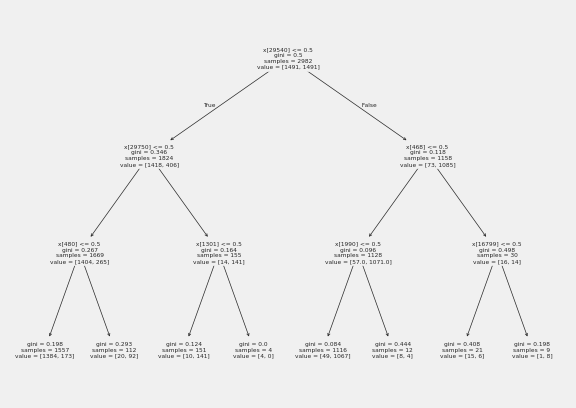

In [ ]:
tree.plot_tree(dt_d3)

In [ ]:
# Define decision tree changing max depth
dt_d2 = tree.DecisionTreeClassifier(max_depth=2)
dt_d2 = dt_d2.fit(X_train_dt, Y_train)

# Make predictions
y_pred_d2 = dt_d2.predict(X_val_dt)

# Print accuracy score
print("=======Accuracy Score===========")
acc_d2 = metrics.accuracy_score(Y_val, y_pred_d2)
print(f"Decision Tree Accuracy: {acc_d2*100:.2f}%")

=======Accuracy Score===========
Decision Tree Accuracy: 89.14%


[Text(0.5, 0.8333333333333334, 'x[29540] <= 0.5\ngini = 0.5\nsamples = 2982\nvalue = [1491, 1491]'),
 Text(0.25, 0.5, 'x[29750] <= 0.5\ngini = 0.346\nsamples = 1824\nvalue = [1418, 406]'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.267\nsamples = 1669\nvalue = [1404, 265]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.164\nsamples = 155\nvalue = [14, 141]'),
 Text(0.75, 0.5, 'x[468] <= 0.5\ngini = 0.118\nsamples = 1158\nvalue = [73, 1085]'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.096\nsamples = 1128\nvalue = [57.0, 1071.0]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.498\nsamples = 30\nvalue = [16, 14]')]

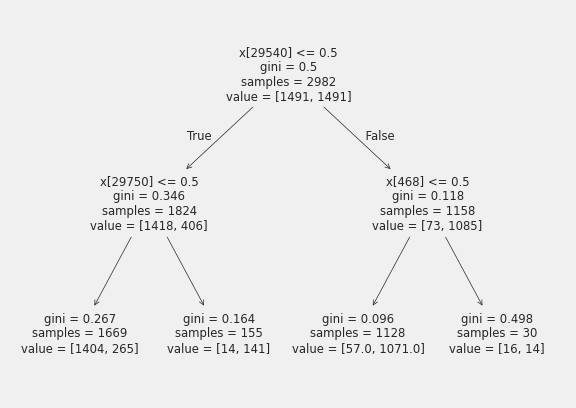

In [ ]:
tree.plot_tree(dt_d2)

In [ ]:
# Define decision tree changing max depth
dt_d5 = tree.DecisionTreeClassifier(max_depth=5)
dt_d5 = dt_d5.fit(X_train_dt, Y_train)

# Make predictions
y_pred_d5 = dt_d5.predict(X_val_dt)

# Print accuracy score
print("=======Accuracy Score===========")
acc_d5 = metrics.accuracy_score(Y_val, y_pred_d5)
print(f"Decision Tree Accuracy: {acc_d5*100:.2f}%")

=======Accuracy Score===========
Decision Tree Accuracy: 93.16%


In [ ]:
# Define decision tree changing min sample split
dt_s2 = tree.DecisionTreeClassifier(min_samples_split=2)
dt_s2 = dt_s2.fit(X_train_dt, Y_train)

# Make predictions
y_pred_s2 = dt_s2.predict(X_val_dt)

# Print accuracy score
print("=======Accuracy Score===========")
acc_s2 = metrics.accuracy_score(Y_val, y_pred_s2)
print(f"Decision Tree Accuracy: {acc_s2*100:.2f}%")

=======Accuracy Score===========
Decision Tree Accuracy: 92.23%


In [ ]:
# Define decision tree changing min sample split
dt_s4 = tree.DecisionTreeClassifier(min_samples_split=4)
dt_s4 = dt_s4.fit(X_train_dt, Y_train)

# Make predictions
y_pred_s4 = dt_s4.predict(X_val_dt)

# Print accuracy score
print("=======Accuracy Score===========")
acc_s4 = metrics.accuracy_score(Y_val, y_pred_s4)
print(f"Decision Tree Accuracy: {acc_s4*100:.2f}%")

=======Accuracy Score===========
Decision Tree Accuracy: 92.36%


In [ ]:
# Define decision tree changing min sample leaf
dt_l2 = tree.DecisionTreeClassifier(min_samples_leaf=2)
dt_l2 = dt_l2.fit(X_train_dt, Y_train)

# Make predictions
y_pred_l2 = dt_l2.predict(X_val_dt)

# Print accuracy score
print("=======Accuracy Score===========")
acc_l2 = metrics.accuracy_score(Y_val, y_pred_l2)
print(f"Decision Tree Accuracy: {acc_l2*100:.2f}%")

=======Accuracy Score===========
Decision Tree Accuracy: 91.15%


In [ ]:
# Define decision tree changing min sample leaf
dt_l4 = tree.DecisionTreeClassifier(min_samples_leaf=4)
dt_l4 = dt_l4.fit(X_train_dt, Y_train)

# Make predictions
y_pred_l4 = dt_l4.predict(X_val_dt)

# Print accuracy score
print("=======Accuracy Score===========")
acc_l4 = metrics.accuracy_score(Y_val, y_pred_l4)
print(f"Decision Tree Accuracy: {acc_l4*100:.2f}%")

=======Accuracy Score===========
Decision Tree Accuracy: 91.69%


In [ ]:
# Define decision tree with all arguments
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=4, min_samples_leaf=2)
clf = clf.fit(X_train_dt, Y_train)

# Make predictions
y_pred_dt = clf.predict(X_val_dt)

# Print accuracy score
print("=======Accuracy Score===========")
acc_dt = metrics.accuracy_score(Y_val, y_pred_dt)
print(f"Decision Tree Accuracy: {acc_dt*100:.2f}%")

accuracies['Decision Tree'] = np.round(acc_dt*100, 2)

=======Accuracy Score===========
Decision Tree Accuracy: 91.69%


[Text(0.5, 0.875, 'x[29540] <= 0.5\ngini = 0.5\nsamples = 2982\nvalue = [1491, 1491]'),
 Text(0.25, 0.625, 'x[29750] <= 0.5\ngini = 0.346\nsamples = 1824\nvalue = [1418, 406]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[480] <= 0.5\ngini = 0.267\nsamples = 1669\nvalue = [1404, 265]'),
 Text(0.0625, 0.125, 'gini = 0.198\nsamples = 1557\nvalue = [1384, 173]'),
 Text(0.1875, 0.125, 'gini = 0.293\nsamples = 112\nvalue = [20, 92]'),
 Text(0.375, 0.375, 'x[1301] <= 0.5\ngini = 0.164\nsamples = 155\nvalue = [14, 141]'),
 Text(0.3125, 0.125, 'gini = 0.124\nsamples = 151\nvalue = [10, 141]'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.75, 0.625, 'x[468] <= 0.5\ngini = 0.118\nsamples = 1158\nvalue = [73, 1085]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[1990] <= 0.5\ngini = 0.096\nsamples = 1128\nvalue = [57.0, 1071.0]'),
 Text(0.5625, 0.125, 'gini = 0.084\nsamples = 1116\nvalue = [49, 1067]'),
 Text(0.6875, 0.125, 'gini = 0.444\nsamples = 12

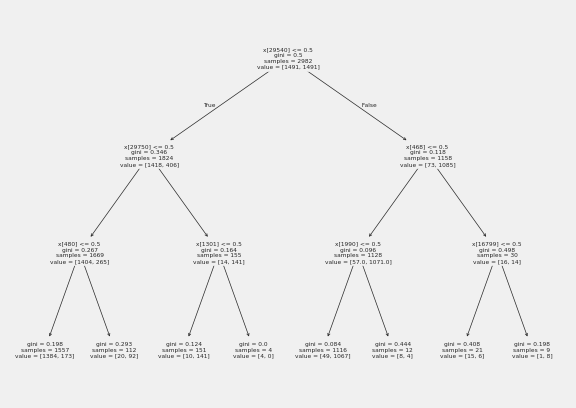

In [ ]:
tree.plot_tree(clf)

# **5. Model Evaluation**

**5.1: Performance Metrics**

In [ ]:
# Store model accuracies for comparison
accuracies['SVM'] = np.round(acc_svm*100, 2)
accuracies['Decision Tree'] = np.round(acc_dt*100, 2)

# Calculate and print the accuracy scores
print("\n=======Accuracy Scores===========")
acc_svm = metrics.accuracy_score(Y_val, y_pred_svm)
acc_dt = metrics.accuracy_score(Y_val, y_pred_dt)

print(f"Support Vector Machine Accuracy: {acc_svm*100:.2f}%")
print(f"Decision Tree Accuracy: {acc_dt*100:.2f}%")

# Print the confusion matrix
print("\n=======Confusion Matrix===========")
print("Support Vector Machine:\n", metrics.confusion_matrix(Y_val, y_pred_svm))
print("Decision Tree:\n", metrics.confusion_matrix(Y_val, y_pred_dt))

# Additional evaluation metrics
print("\n=======Classification Report===========")
print("Support Vector Machine:\n", metrics.classification_report(Y_val, y_pred_svm, target_names=['0','1']))
print("Decision Tree:\n", metrics.classification_report(Y_val, y_pred_dt, target_names=['0', '1']))


=======Accuracy Scores===========
Support Vector Machine Accuracy: 97.72%
Decision Tree Accuracy: 91.69%

=======Confusion Matrix===========
Support Vector Machine:
 [[367   6]
 [ 11 362]]
Decision Tree:
 [[352  21]
 [ 41 332]]

=======Classification Report===========
Support Vector Machine:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       373
           1       0.98      0.97      0.98       373

    accuracy                           0.98       746
   macro avg       0.98      0.98      0.98       746
weighted avg       0.98      0.98      0.98       746

Decision Tree:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       373
           1       0.94      0.89      0.91       373

    accuracy                           0.92       746
   macro avg       0.92      0.92      0.92       746
weighted avg       0.92      0.92      0.92       746



**5.2: Model Comparison**

Support Vector Machine: ROC AUC=0.998
Decision Tree: ROC AUC=0.932


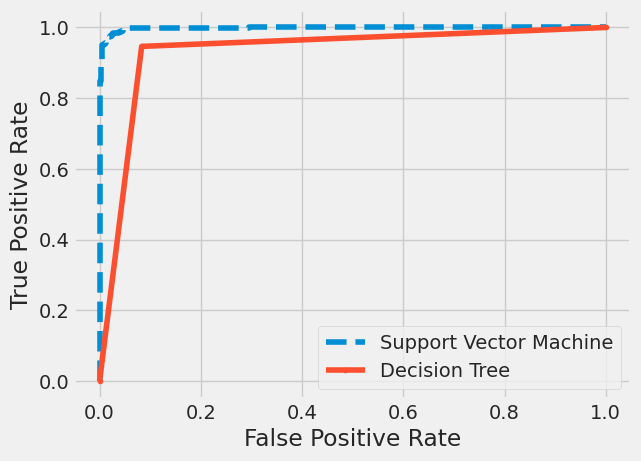

In [ ]:
import matplotlib.pyplot as plt
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict probabilities
sc_probs = sc.predict_proba(X_val_svm)
dt_probs = dt.predict_proba(X_val_dt)
# keep probabilities for the positive outcome only
sc_probs = sc_probs[:, 1]
dt_probs = dt_probs[:, 1]
# calculate scores
sc_auc = roc_auc_score(Y_val, sc_probs)
dt_auc = roc_auc_score(Y_val, dt_probs)
# Store scores for comparison
roc_auc['SVM'] = np.round(sc_auc, 3)
roc_auc['Decision Tree'] = np.round(dt_auc, 3)
# summarize scores
print('Support Vector Machine: ROC AUC=%.3f' % (sc_auc))
print('Decision Tree: ROC AUC=%.3f' % (dt_auc))
# calculate roc curves
sc_fpr, sc_tpr, _ = roc_curve(Y_val, sc_probs)
dt_fpr, dt_tpr, _ = roc_curve(Y_val, dt_probs)
# plot the roc curve for the model
plt.plot(sc_fpr, sc_tpr, linestyle='--', label='Support Vector Machine')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# Create comparison table
comparison_table = pd.DataFrame({
    'Model': ['Support Vector Machine', 'Decision Tree'],
    'Accuracy': [accuracies['SVM'], accuracies['Decision Tree']],
    'ROC AUC': [roc_auc['SVM'], roc_auc['Decision Tree']]
})
print(comparison_table)

                    Model  Accuracy  ROC AUC
0  Support Vector Machine     97.72    0.998
1           Decision Tree     91.69    0.932


As shown above, the Support Vector Machine (SVM) model performs better than the Decision Tree model. It shows a higher accuracy and lower false positive rate. From the f1-score and recall statistics, we can see that the Decision Tree model struggled to predict AI-written essays than human-written essays, indicated by it's lower scores in those categories. Whereas, the SVM model performed steadily in both scenarios.

**5.3: Error Analysis**

In [ ]:
# Get the original index of the validation set
y_val_index = Y_val.index

# Iterate through the indices of Y_val and compare with predictions
# Use the original index to access Y_val and the sequential position i to access y_pred_svm
indices = [y_val_index[i] for i in range(len(Y_val)) if Y_val.iloc[i] != y_pred_svm[i]]

# Use the collected original indices to select rows from the original training DataFrame
wrong_predictions_svm = df_train.loc[indices,:]
print(len(wrong_predictions_svm))

17


In [ ]:
wrong_predictions_svm

,essay,label,essay_len,clean_essay
3008,"From my perspective, I agree that people shoul...",1,149,perspective agree people take risks try new th...
2976,I agree with the statement that successful peo...,1,205,agree statement successful people try new thin...
201,It is often said that all influential TV enter...,0,321,often said influential TV entertainment progra...
2922,"In my opinion, successful people are willing t...",1,181,opinion successful people willing try new thin...
2660,We can‚Äôt group all successful people togethe...,1,166,can‚Äôt group successful people together every...
3525,I completely agree with this statement. I beli...,1,201,completely agree statement believe without tak...
2006,Some people prefer living in stable conditions...,1,247,people prefer living stable conditions follow ...
2864,"These days, there is competition in every fiel...",1,203,days competition every field succeed ones stan...
343,In many countries around the world young peopl...,0,368,many countries around world young people decid...
3530,There are many different kinds of people in th...,1,170,many different kinds people world lot found su...


As we can see from this table, the SVM model struggled more with human-written essays, falsely identifying 11 human-written essays vs 6 AI-written essays. It seems to falsely identify longer, more formal human-written essays as AI, and less formal AI-written essays as human.

In [ ]:
# Get the original index of the validation set
y_val_index = Y_val.index

# Iterate through the indices of Y_val and compare with predictions
# Use the original index to access Y_val and the sequential position i to access y_pred_svm
indices = [y_val_index[i] for i in range(len(Y_val)) if Y_val.iloc[i] != y_pred_dt[i]]

# Use the collected original indices to select rows from the original training DataFrame
wrong_predictions_dt = df_train.loc[indices,:]
print(len(wrong_predictions_dt))

62


In [ ]:
wrong_predictions_dt.head(15)

,essay,label,essay_len,clean_essay
3008,"From my perspective, I agree that people shoul...",1,149,perspective agree people take risks try new th...
2323,"These days, smoking is considered one of the m...",1,249,days smoking considered one harmful habits peo...
3163,Although some people believe that successful i...,1,152,Although people believe successful individuals...
189,The cultural value of engaging with museums an...,0,357,cultural value engaging museums art galleries ...
2267,You should write at least 250 words. You shoul...,1,268,write least 250 words spend 40 minutes task da...
2837,We grow up in a society that promotes the myth...,1,166,grow society promotes myth success Whether you...
1877,Whether people should be encouraged to pursue ...,1,221,Whether people encouraged pursue vocational co...
1882,Some people argue that individuals should stop...,1,331,people argue individuals stop working reach re...
385,There are various numbers of countries that ar...,0,277,various numbers countries rich economic weath ...
3707,I agree with the statement provided. Every suc...,1,255,agree statement provided Every success comes s...


As we can see here, the Decision Tree model resulted an quite a few more incorrect predictions than the SVM model. It seems to struggle more with AI-written essays.

# **6. Results Discussion**

Predict using test data:

In [ ]:
# Instantiate CountVectorizer and fit on training data
vectorizer = CountVectorizer(
    binary=True,        # Use binary features (presence/absence)
    max_features=30000, # Limit vocabulary size for efficiency (30k, same as before)
    ngram_range=(1, 2), # Use unigrams and bigrams
    min_df=2,          # Ignore terms that appear in less than 2 documents
    max_df=0.95        # Ignore terms that appear in more than 95% of documents
)
X_train = vectorizer.fit_transform(df_train['clean_essay'])
X_test = vectorizer.transform(df_test['clean_essay'])
Y_train = df_train['label']

# Implement Support Vector Machine (SVM)
sc = svm.SVC(probability=True)
sc.fit(X_train, Y_train)

# Make predictions
y_pred_class = sc.predict(X_test)

In [ ]:
print(len(y_pred_class))

869


Write results to a csv file:

In [ ]:
# create index array
indexes = np.arange(0, 870)

# convert array into dataframe
prediction_df = pd.DataFrame(list(zip(indexes, y_pred_class)), columns=["essay_id", "predicted_label"])

print(prediction_df)

     essay_id  predicted_label
0           0                0
1           1                0
2           2                0
3           3                0
4           4                0
..        ...              ...
864       864                0
865       865                0
866       866                0
867       867                0
868       868                1

[869 rows x 2 columns]


In [ ]:
# convert dataframe to csv file
prediction_df.to_csv('Emily_Novak_test_R11798447.csv', index=False)